In [1]:
import numpy as np;
import matplotlib.pyplot as plt;
from scipy import ndimage
import pandas as pd;
import os;
import tensorflow as tf
import cv2;
import time
import math
%matplotlib inline

In [3]:
print (os.getcwd())
directory = sorted(os.listdir("Face"));
directory.remove('.ipynb_checkpoints')

/home/vigneshj6/FaceProject


378348
10000
20000
30000
40000
50000
179 bill gates


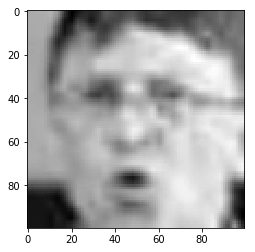

60000
70000
80000
90000
100000
368 del toro


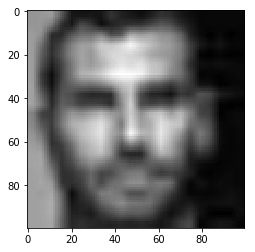

110000
120000
130000
140000
150000
597 heather graham


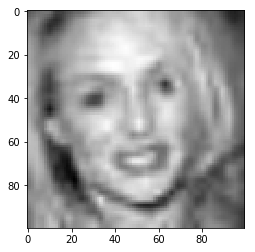

160000
170000
180000
190000
200000
790 joseph ratzinger


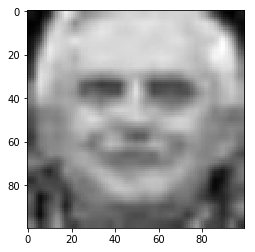

210000
220000
230000
240000
250000
985 mahmoud ahmadinejad


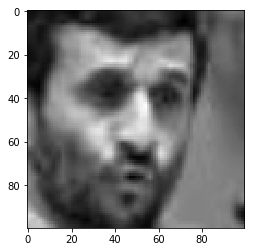

260000
270000
280000
290000
300000
1192 pamela anderson


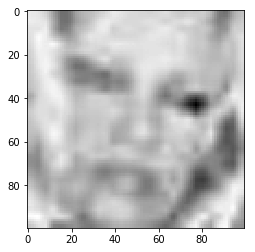

310000
320000
330000
340000
350000
1428 steve jobs


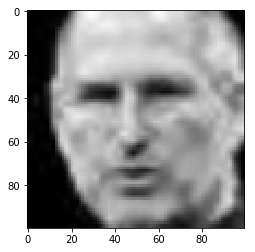

360000
370000
(378348, 100, 100)
(378348,)
1581


In [4]:


train_size = 0;
for label in directory:
    train_size = train_size + len(os.listdir("Face/"+str(label)));
print (train_size)
count = 0
pixel = 100; #change the pixel size if the data set changes
image_size = 100;
#Depending on the size, X(Features) and Y(Labels) get initialized to zero.
train_data_X = np.zeros((train_size,pixel,pixel),dtype=float)
#train_data_Y = np.zeros((train_size,9),dtype=float)
train_data_Y= np.zeros((train_size),dtype=np.int32)
#It loads the true values and puts it in the train_data_X and sets train_data_y=1 ;

permutation = np.random.permutation(train_size);

for label in directory:
    images = os.listdir("Face/"+str(label));
    for i in images:
        img = np.array(plt.imread('Face/'+str(label)+'/'+i),dtype=float);
        train_data_X[permutation[count]]=(img-img.min())/(img.max()-img.min());#normalizes the data
        train_data_Y[permutation[count]] = (directory.index(label));
        count = count+1
        if(count%10000==0):
            print(count)
        if(count%50000==0):
            l = permutation[count-1]
            print(train_data_Y[l],directory[train_data_Y[l]])
            plt.imshow(train_data_X[l],cmap='gray')
            plt.show()
print (train_data_X.shape)
print (train_data_Y.shape)
label_count=len(directory)
print (label_count)
total = train_size


barack obama


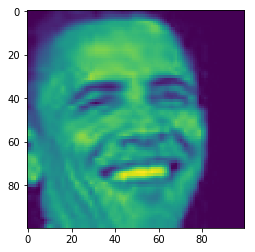

lucas cranach


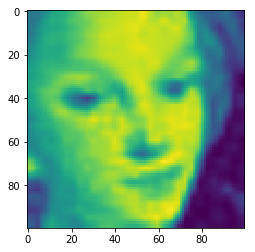

vanessa hudgens


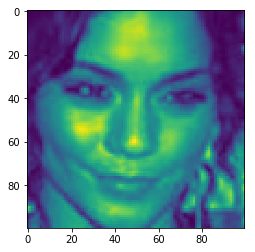

sharon stone


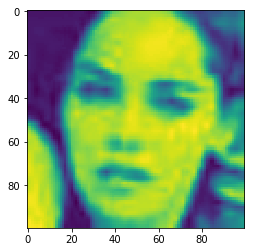

jennifer lopez


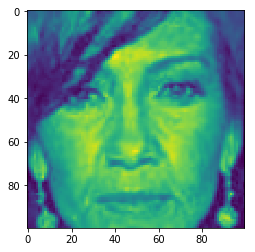

sigourney weaver


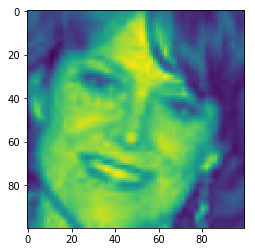

diane lane


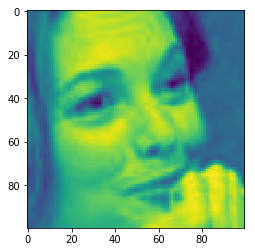

selena gomez


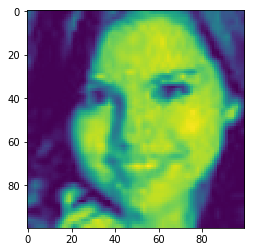

angelina jolie


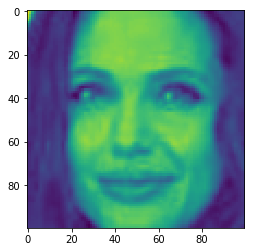

mischa barton


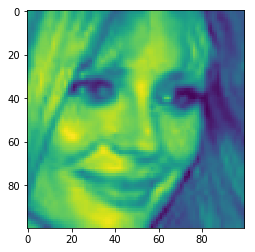

In [5]:
sample = range(10);
for samp in sample:
    print (directory[train_data_Y[samp]])
    plt.imshow(train_data_X[samp],cmap='gray')
    plt.show()

In [6]:
train_size = int(train_size/100)*100
valid_size = int(train_size/10);
valid_size = int(valid_size/100)*100
end = train_size;
train_size = train_size - valid_size;
X_train = train_data_X[0:train_size].reshape(train_size,(image_size**2));
y_train = train_data_Y[0:train_size][:].astype(np.int32)
X_test = train_data_X[train_size:end].reshape(train_data_X[train_size:end].shape[0],(image_size**2));
y_test = train_data_Y[train_size:end][:].astype(np.int32)
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(340500, 10000)
(340500,)
(37800, 10000)
(37800,)


## Hyper Parameters for CNN

In [7]:
label_count=len(directory)
image_size = 100
image_size_flat = image_size * image_size
image_shape = (image_size, image_size)
num_channels=1
num_labels = label_count #Currently there are 30 Labels
print(num_labels)
num_iterations = 10000
batch_size = 100
alpha = 0.0001;
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.
conv_stride1=[1,1,1,1]
# Convolutional Layer 2.
filter_size2 = 4          # Convolution filters are 4 x 4 pixels.
num_filters2 = 32         # There are 32 of these filters.
conv_stride2=[1,1,1,1]
# Convolutional Layer 3.
filter_size3 = 3          # Convolution filters are 3 x 3 pixels.
num_filters3 = 48         # There are 48 of these filters.
conv_stride3=[1,2,2,1]
# Fully-connected layer.
fc_size = 160             # Number of neurons in fully-connected layer.

1581


In [8]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
      mean = tf.reduce_mean(var)
      tf.summary.scalar('mean', mean)
      with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
      tf.summary.scalar('stddev', stddev)
      tf.summary.scalar('max', tf.reduce_max(var))
      tf.summary.scalar('min', tf.reduce_min(var))
      tf.summary.histogram('histogram', var)

def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))
def new_conv_layer(name,input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   list_strides,
                   use_pooling=True     # Use 2x2 max-pooling.
                   ): 

    with tf.name_scope(name):
        # Shape of the filter-weights for the convolution.
        # This format is determined by the TensorFlow API.
        shape = [filter_size, filter_size, num_input_channels, num_filters]
        # Create new weights aka. filters with the given shape.
        with tf.name_scope('ConvWeights'):
            weights = new_weights(shape=shape)
            variable_summaries(weights)
        # Create new biases, one for each filter.
        with tf.name_scope('ConvBiases'):
            biases = new_biases(length=num_filters)
            variable_summaries(weights)
        # Create the TensorFlow operation for convolution.
        # Note the strides are set to 1 in all dimensions.
        # The first and last stride must always be 1,
        # because the first is for the image-number and
        # the last is for the input-channel.
        # But e.g. strides=[1, 2, 2, 1] would mean that the filter
        # is moved 2 pixels across the x- and y-axis of the image.
        # The padding is set to 'SAME' which means the input image
        # is padded with zeroes so the size of the output is the same.
        layer = tf.nn.conv2d(input=input,
                             filter=weights,
                             strides=list_strides,
                             padding='SAME',
                             use_cudnn_on_gpu=True)
        # Add the biases to the results of the convolution.
        # A bias-value is added to each filter-channel.
        layer += biases
        # Use pooling to down-sample the image resolution?
        if use_pooling:
            # This is 2x2 max-pooling, which means that we
            # consider 2x2 windows and select the largest value
            # in each window. Then we move 2 pixels to the next window.
            layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
        # Rectified Linear Unit (ReLU).
        # It calculates max(x, 0) for each input pixel x.
        # This adds some non-linearity to the formula and allows us
        # to learn more complicated functions.
        layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    
    return layer, weights
 

def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features
def new_fc_layer(name,input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    with tf.name_scope(name):
        # Create new weights and biases.
        with tf.name_scope('Weights'):
            weights = new_weights(shape=[num_inputs, num_outputs])
            variable_summaries(weights)
        with tf.name_scope('Biases'):
            biases = new_biases(length=num_outputs)
            variable_summaries(biases)
        # Calculate the layer as the matrix multiplication of
        # the input and weights, and then add the bias-values.
        layer = tf.matmul(input, weights) + biases
        # Use ReLU?
        if use_relu:
            layer = tf.nn.relu(layer)

    return layer

In [9]:
x = tf.placeholder(tf.float32, shape=[None, image_size_flat], name='x')
x_image = tf.reshape(x, [-1, image_size, image_size, num_channels])
y_true = tf.placeholder(tf.int64, shape=[batch_size], name='y_true')
#y_true_cls = tf.argmax(y_true, dimension=1)
#Convolutional Layer 1
layer_conv1, weights_conv1 = \
    new_conv_layer('ConvLayer1',input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   list_strides=conv_stride1,
                   use_pooling=True
                   )


In [10]:
layer_conv1

<tf.Tensor 'ConvLayer1/Relu:0' shape=(?, 50, 50, 16) dtype=float32>

In [11]:
#Convolutional Layer 2
layer_conv2, weights_conv2 = \
    new_conv_layer('ConvLayer2',input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   list_strides=conv_stride2,
                   use_pooling=True
                   )

In [12]:
layer_conv2

<tf.Tensor 'ConvLayer2/Relu:0' shape=(?, 25, 25, 32) dtype=float32>

In [13]:
#Convolutional Layer 3
layer_conv3, weights_conv3 = \
    new_conv_layer('ConvLayer3',input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   list_strides=conv_stride3,
                   use_pooling=True
                   )

In [14]:
layer_conv3

<tf.Tensor 'ConvLayer3/Relu:0' shape=(?, 7, 7, 48) dtype=float32>

In [15]:
#Flattening the Output of the Convolutional Layer 3
layer_flat, num_features = flatten_layer(layer_conv3)

In [16]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 2352) dtype=float32>

In [17]:
num_features

2352

In [18]:
layer_fc1 = new_fc_layer(name='FCLayer1',input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [19]:
layer_fc1

<tf.Tensor 'FCLayer1/Relu:0' shape=(?, 160) dtype=float32>

In [20]:
layer_fc2 = new_fc_layer(name='OutputLayer',input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_labels,
                         use_relu=False)

In [21]:
layer_fc2

<tf.Tensor 'OutputLayer/add:0' shape=(?, 1581) dtype=float32>

In [22]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)
with tf.name_scope('loss'):
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
    cost = tf.reduce_mean(cross_entropy)
tf.summary.scalar('loss', cost)
optimizer = tf.train.AdamOptimizer(learning_rate=alpha).minimize(cost)

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(y_pred_cls, y_true)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('accuracy',accuracy)

<tf.Tensor 'accuracy_1:0' shape=() dtype=string>

# Plotting the Convolutional Weights

In [23]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

# Plotting the outputs of Convolutional Layer

In [24]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    return fig;

In [25]:
def accuracy_validation(predictions, labels):
    eq = (predictions == labels)
    return ((100.0 * np.sum(eq))/eq.size)

In [26]:
def run_validation(X_test):
    count = 0;
    result = [];
    for i in range(int(X_test.shape[0]/100)):
        result.extend(session.run(y_pred_cls,feed_dict={x:X_test[count:count+100]}))
        count = count+100;
    acc = accuracy_validation(y_test,result)
    print ('---> Validation Accuracy',acc)
    return acc

In [27]:
os.chdir('Models')

In [28]:

model_name = 'model';
n=0;
while 1:
    if not os.path.exists(model_name+str(n)):
        os.mkdir(model_name+str(n));
        model_name = model_name+str(n)
        break;
    n = n+1;
print(model_name)

model0


In [30]:
session=tf.Session()
session.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter(model_name+"/",session.graph)
summary=tf.summary.merge_all();
saver = tf.train.Saver();
load_path = str(input("enter the load dirctory name"));
saver.restore(sess=session, save_path=load_path)
save_path = model_name+'/model';
print("Initialized")

offset=0
best = 0
for step in range(num_iterations):
    offset = (step * batch_size) % (X_train.shape[0] - batch_size)
    batch_data = X_train[offset:(offset + batch_size), :]
    batch_labels = y_train[offset:(offset + batch_size)]
    feed_dict = {x : batch_data, y_true : batch_labels}        
    _, l, acc,s = session.run([optimizer, cost, accuracy,summary],feed_dict=feed_dict)
    if ((step % 5000 == 0) or (step == num_iterations-1)):
        curr = run_validation(X_test);
        if(curr>best):
            best = curr;
            print (best)
            saver.save(session,save_path)
    if ((step % 500 == 0)or (step == num_iterations-1)):
        print("Minibatch loss at step %d: %f" % (step, l))
        print("mini batch accuracy: ", acc)            
        writer.add_summary(s,step)
        writer.flush()
print("Model saved in file: %s" % save_path)
print("done")


enter the load dirctory name../FaceModels/model1
Initialized
---> Validation Accuracy 63.619047619
63.619047619
Minibatch loss at step 0: 1.545871
mini batch accuracy:  0.67
Minibatch loss at step 500: 1.498915
mini batch accuracy:  0.73
Minibatch loss at step 1000: 1.724108
mini batch accuracy:  0.64
Minibatch loss at step 1500: 1.359058
mini batch accuracy:  0.73
Minibatch loss at step 2000: 1.491297
mini batch accuracy:  0.72
Minibatch loss at step 2500: 1.558115
mini batch accuracy:  0.71
Minibatch loss at step 3000: 1.528010
mini batch accuracy:  0.69
Minibatch loss at step 3500: 1.040531
mini batch accuracy:  0.8
Minibatch loss at step 4000: 1.435411
mini batch accuracy:  0.69
Minibatch loss at step 4500: 1.534639
mini batch accuracy:  0.77
---> Validation Accuracy 69.7724867725
69.7724867725
Minibatch loss at step 5000: 2.019748
mini batch accuracy:  0.65
Minibatch loss at step 5500: 1.826788
mini batch accuracy:  0.68
Minibatch loss at step 6000: 1.543897
mini batch accuracy:  

# Filters of Convolutional Layer 1(red is closer to maximum, blue is closer to minimum)

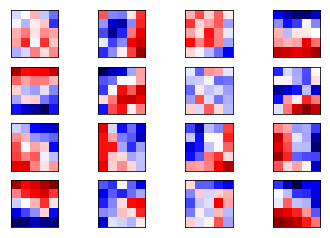

In [31]:
plot_conv_weights(weights=weights_conv1)

# Filters of Convolutional Layer 2

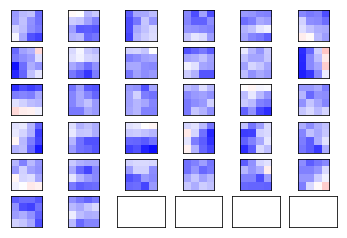

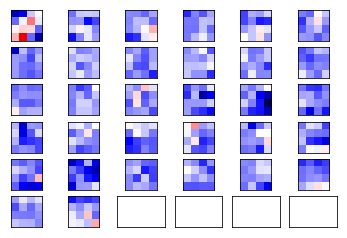

In [32]:
plot_conv_weights(weights=weights_conv2,input_channel=0)
plot_conv_weights(weights=weights_conv2,input_channel=1)

# Filters of Convolutional Layer 3

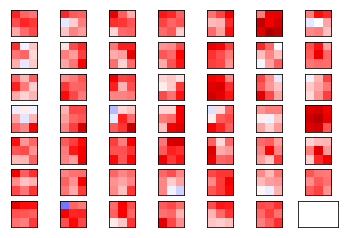

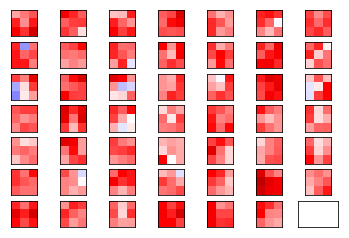

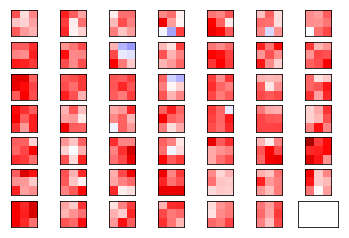

In [33]:
plot_conv_weights(weights=weights_conv3,input_channel=0)
plot_conv_weights(weights=weights_conv3,input_channel=1)
plot_conv_weights(weights=weights_conv3,input_channel=2)

154
barack obama


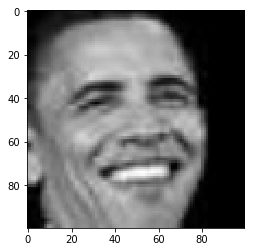

966
lucas cranach


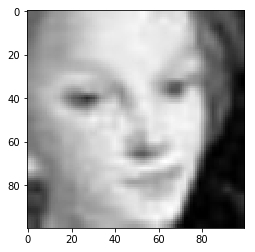

1515
vanessa hudgens


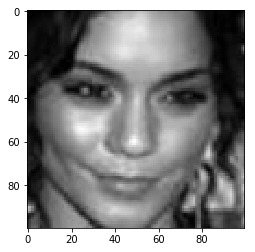

1385
sharon stone


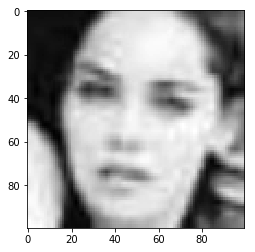

705
jennifer lopez


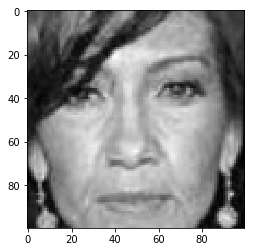

1398
sigourney weaver


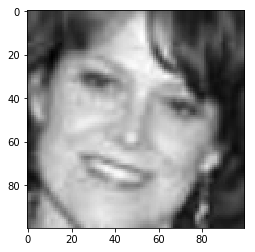

384
diane lane


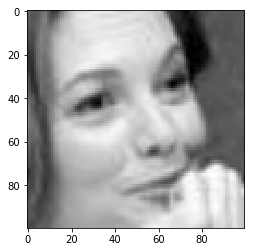

1372
selena gomez


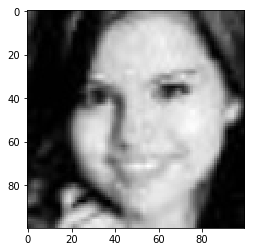

91
angelina jolie


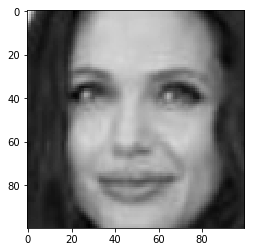

1112
mischa barton


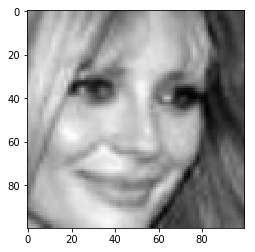

In [34]:
for i in range(0,len(train_data_X[:10])):
    print(train_data_Y[i])
    print(directory[train_data_Y[i]])
    plt.imshow(train_data_X[i],cmap='gray');
    plt.show();

In [35]:
#Puts the Convolution Plots into a directory
def print_convImage(layer,image,name):
    directory = 'Convolution/Images/'+str(layer.name.split('/')[0])
    if not os.path.exists(directory):#if directory is not available, creates a new directory.
        os.makedirs(directory)
    fig = plot_conv_layer(layer=layer,image=image)
    fig.savefig(directory+'/'+str(name)+'.png');
    

Image 0


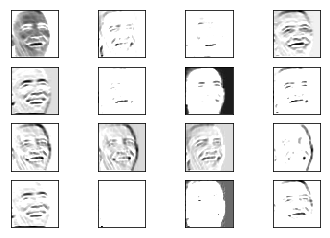

Image 1


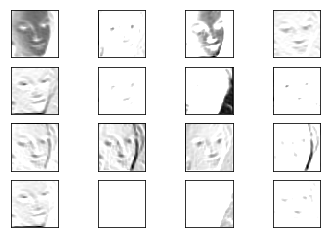

Image 2


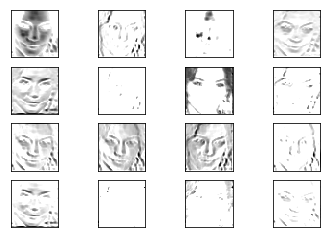

Image 3


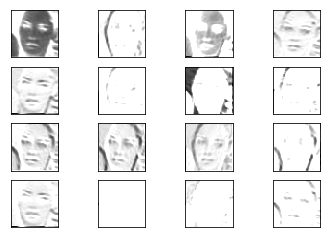

Image 4


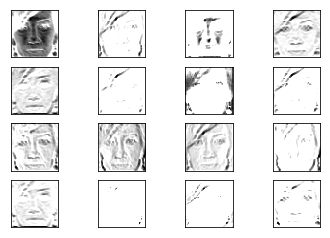

Image 5


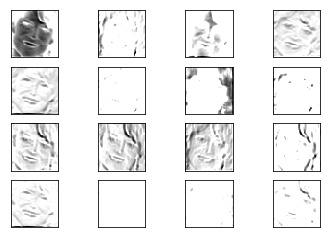

Image 6


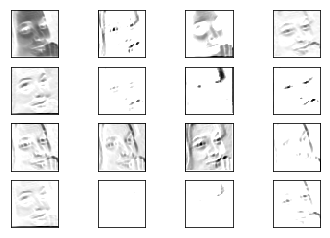

Image 7


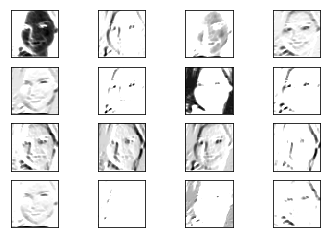

Image 8


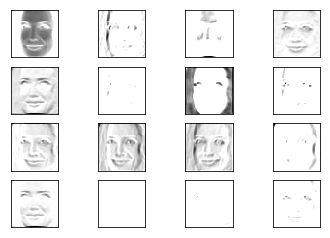

Image 9


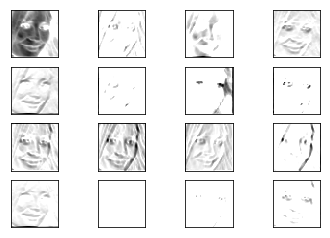

In [36]:

for i in range(10):
    print('Image',i)
    print_convImage(layer=layer_conv1,image=X_train[i],name=i)

Image 0


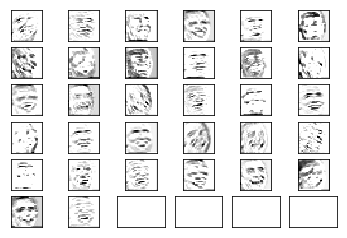

Image 1


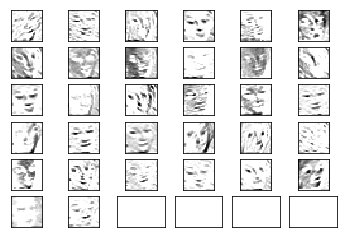

Image 2


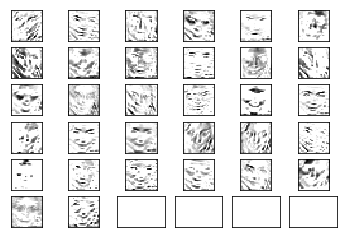

Image 3


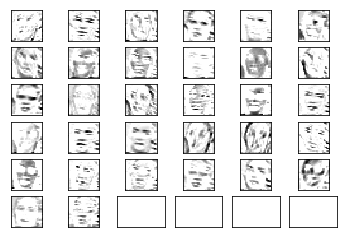

Image 4


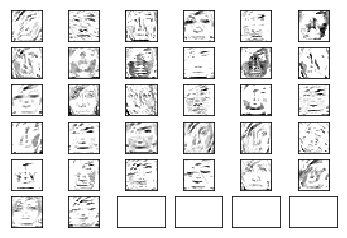

Image 5


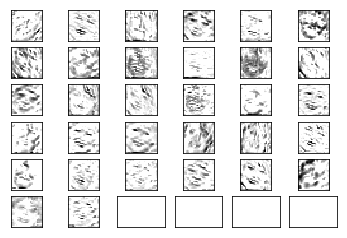

Image 6


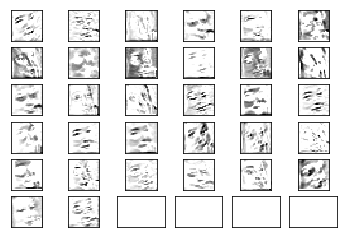

Image 7


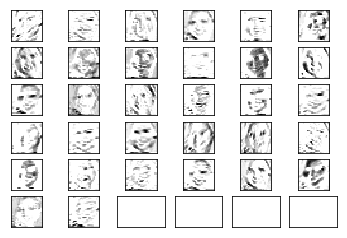

Image 8


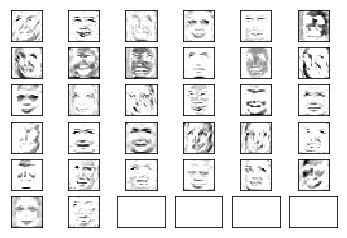

Image 9


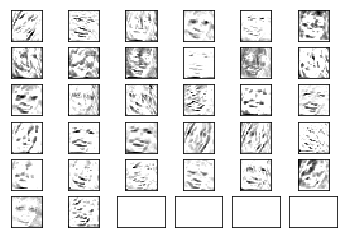

In [37]:
for i in range(10):
    print('Image',i)
    print_convImage(layer=layer_conv2,image=X_train[i],name=i)

Image 0


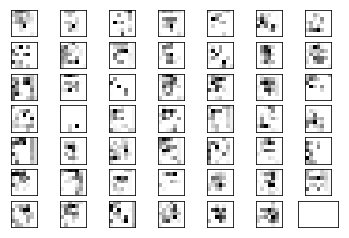

Image 1


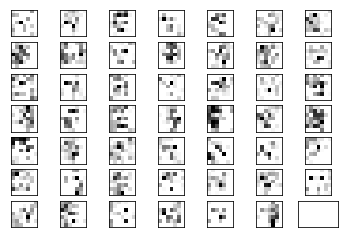

Image 2


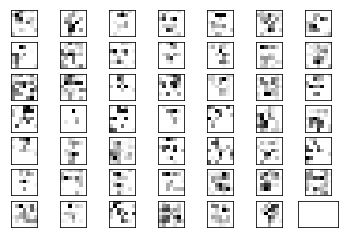

Image 3


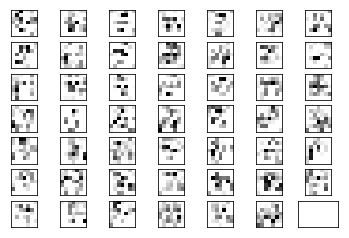

Image 4


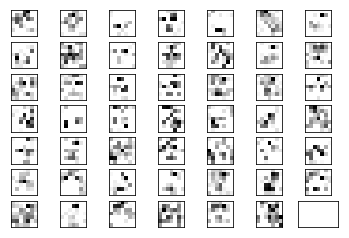

Image 5


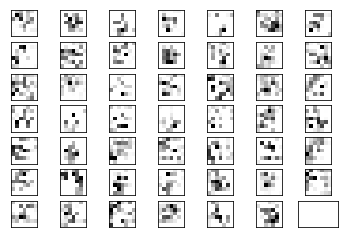

Image 6


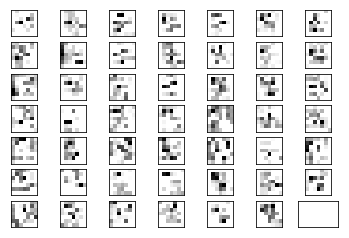

Image 7


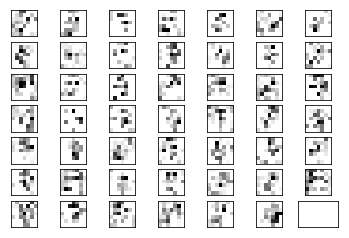

Image 8


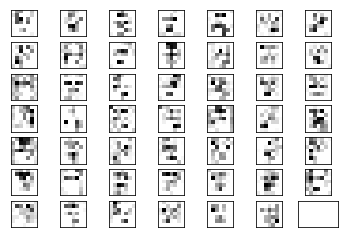

Image 9


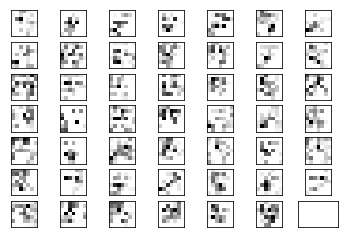

In [38]:
for i in range(10):
    print('Image',i)
    print_convImage(layer=layer_conv3,image=X_train[i],name=i)

['2016-06-23-012617.jpg', 'billgates_759.jpg', 'eminem 1998.jpg', '_93339876_obamalaughing.jpg', 'aishwarya-rai-without-makeup.jpg', 'bob-marley-wallpaper1.jpg', 'Selena-Gomez.jpg', '2016-05-12-1463068419-8483431-michelleobamathumb.jpg', 'Angelina-Jolie-and-Brad-Pitt.jpg', '14-50-cent.w529.h352.jpg', 'Fhkv4dIeRidvXtUPhL4g_steve-jobs.jpg', '011016-jennifer-lopez-lead.jpg', 'Aamir_Khan_at_Satyamev_Jayate_press_conference_13.jpg', 'bruce-lee-9542095-1-402.jpg', 'aishwarya-rai-bachchan__631470.JPG', '2016-04-07-220559.jpg', '2016-04-07-220348.jpg']
0.999963
bill gates


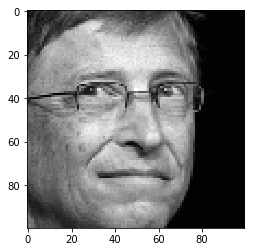

0.999963
barack obama


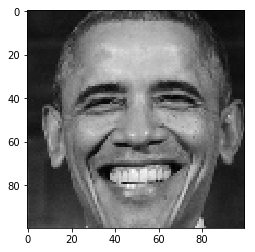

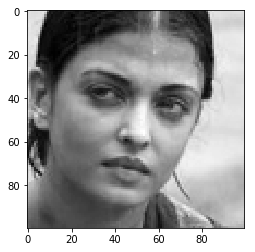

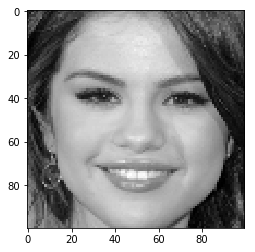

0.999963
michelle obama


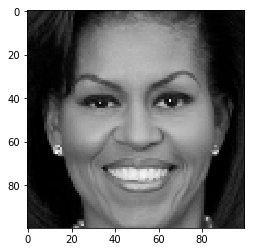

0.999963
brad pitt


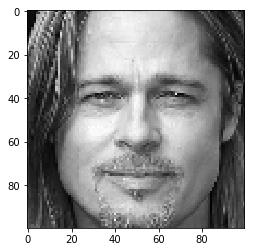

0.999963
50 cent


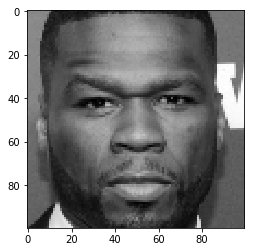

0.999963
steve jobs


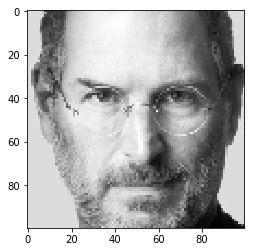

0.999963
jennifer lopez


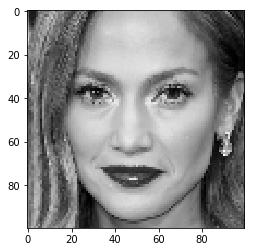

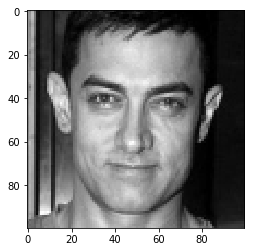

0.999963
bruce lee


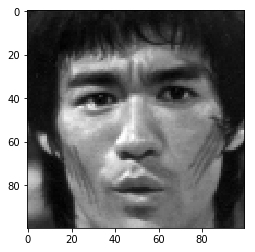

0.999963
aishwarya rai


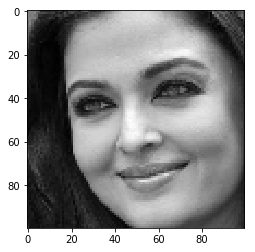

0.999963
vigneshwaran


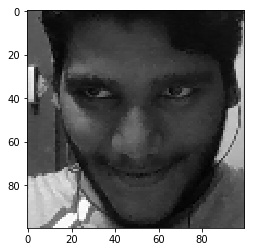

0.999963
vigneshwaran


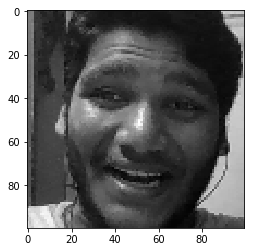

In [59]:
"""
session = tf.Session()
saver = tf.train.Saver();
save_dir = 'FaceModels'
save_path = str(input("enter the model directory"));
saver.restore(sess=session, save_path=save_path)
"""
face_cascade = cv2.CascadeClassifier('../haarcascade_frontalface_alt2.xml')
cnt= 0;
APPROX = 15;
pixel=100

images = os.listdir("../test");
images.remove('.ipynb_checkpoints')
print(images)
l = len(images)

test_data = np.zeros([l,100,100])

for i in images:
    img = cv2.imread('../test/'+i,0);
    faces = face_cascade.detectMultiScale(img, 1.3, 5)
    for (x1,y,w,h) in faces:
        roi_gray = np.array(img[y-APPROX:y+h+APPROX, x1-APPROX:x1+w+APPROX],dtype=float)
        img = cv2.resize(roi_gray, (pixel, pixel))
        test_data[cnt] = (img-img.min())/(img.max()-img.min());
        cnt = cnt+1
        break;

[recognized,val] = session.run([y_pred_cls,y_pred],feed_dict={x:test_data.reshape(l,100*100)})

for i in range(cnt):
    if val[i].max() > 0.5:
        print(val[i].max())
        print(directory[int(recognized[i])])
    plt.imshow(test_data[i],cmap='gray')
    plt.show()

    

In [60]:
val = session.run(y_pred,feed_dict={x:test_data.reshape(l,100*100)})
for i in range(l):
    print(val[i].max())
    print(directory[int(recognized[i])])


0.999815
bill gates
0.997632
barack obama
0.223982
halle berry
0.310005
sofia vergara
0.999836
michelle obama
0.999953
brad pitt
0.999474
50 cent
0.943528
steve jobs
0.9001
jennifer lopez
0.320725
milo ventimiglia
0.999963
bruce lee
0.988277
aishwarya rai
0.993839
vigneshwaran
0.952449
vigneshwaran
0.272154
michael jackson
0.272154
michael jackson
0.272154
michael jackson


In [46]:
for i in range(l):
    print(val[i].max())

0.999952
0.998619
0.181387
0.193583
0.999977
0.999767
0.999589
0.988568
0.880667
0.320238
0.702128
0.999956
0.906497
0.98027
0.886983
0.272154
0.272154
0.272154
0.272154


In [ ]:
session.close()
print(tf.__version__)